In [60]:
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Dropout2d
from torch.autograd import Variable
from torch.optim import Adam, SGD
import torch.nn.functional as F
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import os

# PART 1. CNN Model

### Step 1. Load data

In [2]:
def get_images_array(imageFile, dataPath):
    with open(imageFile, "r") as f:
        images =  []
        labels = []
        for image in f:
            image =image.replace("\n", "")
            if 'NonCOVID' in imageFile:
                image = imread(dataPath + '/CT_NonCOVID/' + image, as_gray=True)
                image = resize(image, [200, 200])
                image = image.astype('float32')
                image /= 255
                images.append(image)
                labels.append(0)
            else:
                image = imread(dataPath + '/CT_COVID/' + image, as_gray=True)
                image = resize(image, [200, 200])
                image = image.astype('float32')
                image /= 255
                images.append(image)
                labels.append(1)
        return images,labels
            

In [3]:
base_dir= '../../../data'
train_im, train_labels = get_images_array(base_dir+'/Data-split/COVID/trainCT_COVID.txt', base_dir)
train_imNC, train_labels_nc = get_images_array(base_dir+'/Data-split/NonCOVID/trainCT_NonCOVID.txt', base_dir)
train_im.extend(train_imNC)
train_labels.extend(train_labels_nc)

train_features = np.array(train_im)
train_labels = np.int64(np.array(train_labels))

test_im, test_labels = get_images_array(base_dir+'/Data-split/COVID/testCT_COVID.txt', base_dir)
test_im_nc, test_labels_nc = get_images_array(base_dir+'/Data-split/NonCOVID/testCT_NonCOVID.txt', base_dir)
test_im.extend(test_im_nc)
test_labels.extend(test_labels_nc)

test_features = np.array(test_im)
test_labels = np.int64(np.array(test_labels))

print(train_features.shape)

(425, 200, 200)


### Step 2. Visualize data

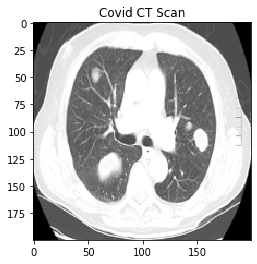

In [4]:
## covid ct scan
index = np.argmin(train_labels)
plt.title("Covid CT Scan")
plt.imshow(train_im[index], 'gray')
assert(np.min(train_labels) == 0)

plt.show()

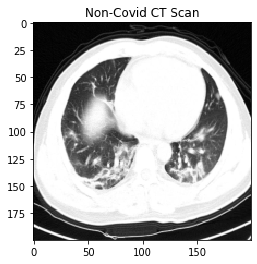

In [5]:
## non-covid ct scan
index = np.argmax(train_labels)
plt.title("Non-Covid CT Scan")
plt.imshow(train_im[index], 'gray')
assert(np.max(train_labels) == 1)
plt.show()

### Step 3. Split data into training, validation, and test sets

In [54]:
train_x, val_x, train_y, val_y = train_test_split(train_features, train_labels, test_size = 0.05)

train_x = train_x.reshape(403, 1, 200, 200)
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
val_x = val_x.reshape(22, 1, 200, 200)
val_x = torch.from_numpy(val_x)
val_y = torch.from_numpy(val_y)

test_features = test_features.reshape(203, 1, 200, 200)
test_x = torch.from_numpy(test_features)
test_y = torch.from_numpy(test_labels)

print("Training set shape:", train_x.shape)
print("Test set shape:", test_x.shape)
print("Validation set shape:", val_x.shape)

Training set shape: torch.Size([403, 1, 200, 200])
Test set shape: torch.Size([203, 1, 200, 200])
Validation set shape: torch.Size([22, 1, 200, 200])


### Step 4. Build CNN model

In [55]:
class CNN(Module):   
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(10000, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [56]:
model = CNN()
#Load model
# model.load_state_dict(torch.load("../../models/covid_cnn.pth"))

In [57]:
print(model)
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()

# if torch.cuda.is_available():
#     model = model.cuda()
#     criterion = criterion.cuda()

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=10000, out_features=10, bias=True)
  )
)


### Step 5. Train model

In [58]:
def train_cnn():
    model.train()
    loss = 0
    trainx = Variable(train_x)
    trainy = Variable(train_y)
    valx = Variable(val_x)
    valy = Variable(val_y)
   
    optimizer.zero_grad()
    train_out = model(trainx)
    val_out = model(valx)
    train_loss = criterion(train_out, trainy)
    val_loss = criterion(val_out, valy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    train_loss.backward()
    optimizer.step()
    loss = train_loss.item()
    print('Epoch : ',epoch+1, '\t', 'loss :', val_loss.item())
    return val_loss

In [59]:
n_epochs = 10
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_cnn()

Epoch :  1 	 loss : 2.4389781951904297
Epoch :  2 	 loss : 0.7258982062339783
Epoch :  3 	 loss : 5.719595909118652
Epoch :  4 	 loss : 22.980302810668945
Epoch :  5 	 loss : 102.68502807617188
Epoch :  6 	 loss : 112.78361511230469
Epoch :  7 	 loss : 62.864261627197266
Epoch :  8 	 loss : 11.230636596679688
Epoch :  9 	 loss : 5.184453964233398
Epoch :  10 	 loss : 2.810342311859131


### Step 6. Data visualization

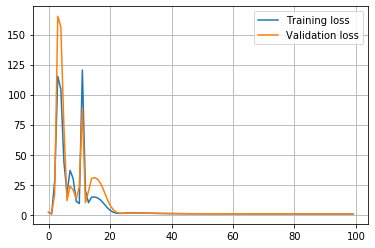

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.grid()
plt.show()

In [45]:
with torch.no_grad():
    output = model(train_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)


# accuracy on training set
print("Train ACCURACY", accuracy_score(train_y, predictions))

Train ACCURACY 0.5654450261780105


In [46]:
with torch.no_grad():
    output = model(val_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
print("Validation accuracy", accuracy_score(val_y, predictions))

Validation accuracy 0.4186046511627907


In [47]:
with torch.no_grad():
    output = model(test_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)


# accuracy on test set
print("Test accuracy", accuracy_score(test_y, predictions))

Test accuracy 0.5172413793103449


In [16]:
#Read more: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), "../../models/covid_cnn.pth")

# Part 2: Conformal Prediction

In [17]:
def euclid(point, centroid):
    """Calculate the distance between a test point and a centroid point"""
    #assuming point and centroid are tensors
    point = np.array(point.tolist())
    centroid = np.array(centroid.tolist())
    return np.linalg.norm(point - centroid)

In [18]:
def centroid(data):
    """Find the centroid for one class of object"""
    #print(data.shape)
    features, observations = data.shape
    if(features > observations):
        raise ValueError("too few observations")
    
    central = []
    for i in range(features):
        mean = torch.mean(data[i])
        central.append(mean)
    return torch.FloatTensor(central).to(device)

In [19]:
### todo...